# pybela drumsynth

In this notebook we'll look at using pybela to capture onset features from the drumsynth project. This includes a Bela project that has been updated to log onset energy and spectral centroid audio features computed at detected onsets using `Watcher`. We'll look at training a small MLP to regress synthesis parameters based on those features.

First, establish a connection with Bela and copy the project.

In [ ]:
! ssh-keyscan bela.local >> ~/.ssh/known_hosts

In [27]:
! rsync -rvL bela-drumsynth/drumsynth-dataset-recording/ root@bela.local:Bela/projects/drumsynth-dataset-recording/
! rsync -rvL bela-drumsynth/src/ root@bela.local:Bela/projects/drumsynth-dataset-recording/

Transfer starting: 6 files
./DrumController.cpp
./DrumController.h
./Watcher.cpp
./Watcher.h
./render.cpp

sent 5545 bytes  received 478 bytes  12046 bytes/sec
total size is 39351  speedup is 6.53
Transfer starting: 15 files
./AppOptions.h
./DrumControllerInference.h
./Envelope.cpp
./Envelope.h
./EnvelopeFollower.h
./Noise.cpp
./Noise.h
./OnsetDetection.cpp
./OnsetDetection.h
./SnareDrum.cpp
./SnareDrum.h
./Tonal.cpp
./Tonal.h
./cxxopts.hpp

sent 1511 bytes  received 988 bytes  1666 bytes/sec
total size is 71854  speedup is 28.75


In [1]:
from pybela import Logger
import matplotlib.pyplot as plt
import pickle

## 1 - Collect dataset
To collect data run the `drumsynth-dataset-recording` project on Bela (you can do so from web-based IDE).

In [2]:
logger=Logger()
logger.connect()

Running in Jupyter notebook. Enabling nest_asyncio.
Connection successful


1

In [3]:
variables = ["onsetEnergy", "spectralCentroid"]
data = {}

Record data for three different classes -- run this cell three times and update the classes [0,1,2]

In [6]:
class_num = 0
read_time = 10

file_paths = logger.start_logging(variables=variables, transfer=True, logging_dir="data/")
logger.wait(read_time)
logger.stop_logging()

# Extract the data from the binary
raw_sc = logger.read_binary_file(file_path=file_paths["local_paths"]["spectralCentroid"], timestamp_mode="sparse")
raw_oe = logger.read_binary_file(file_path=file_paths["local_paths"]["onsetEnergy"], timestamp_mode="sparse")

spectral_centroid = []
onset_energy = []

# Loop through all the buffers and each data point in each buffer.
# pybela appends zeros to the end of buffers so disregard those if values
# in each variable are both zeros.
for sc_buffer, oe_buffer in zip(raw_sc['buffers'], raw_oe['buffers']):
    for x, y in zip(sc_buffer['data'], oe_buffer['data']):
        if x == 0 and y == 0:
            continue
        spectral_centroid.append(x)
        onset_energy.append(y)

assert len(spectral_centroid) == len(onset_energy)
print(f"Found {len(spectral_centroid)} points")

data[class_num] = {
    "sc": spectral_centroid,
    "oe": onset_energy,
}

Started logging variables ['onsetEnergy', 'spectralCentroid']... Run stop_logging() to stop logging.
Stopped logging variables ['spectralCentroid', 'onsetEnergy']...
Transferring /root/Bela/projects/pybela-drumsynth/spectralCentroid+12.bin-->data/spectralCentroid+12.bin...Done.
Done.
Found 141 points


In [7]:
# save data -- in case the kernel dies
with open(f"data/data.pkl", "wb") as f:
    pickle.dump(data, f)

In [8]:
# load data from pickle
with open(f"data/data.pkl", "rb") as f:
    data = pickle.load(f)

## 2 - Visualize Data

Let's look at the data we collected from audio features

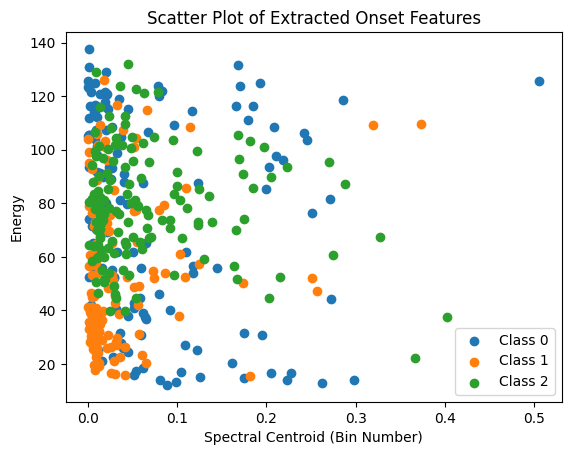

In [9]:
for k,v in data.items():
    plt.scatter(v["sc"], v["oe"], label=f"Class {k}")
    
plt.xlabel("Spectral Centroid (Bin Number)")
plt.ylabel("Energy")
plt.title("Scatter Plot of Extracted Onset Features")
plt.legend()
plt.show()

## 3 - Train model

Now let's train a model to map from these values to different synth presets

In [10]:
import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm 
import pprint as pp
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
# These are manually selected presets for each class
preset_1 = [0.30, 0.60, 0.30, 0.92, 0.75, 0.50, 0.50]
preset_2 = [0.77, 0.35, 0.12, 0.37, 0.24, 0.76, 0.64]
preset_3 = [0.16, 0.50, 0.53, 0.77, 0.20, 0.30, 0.50]
presets = [preset_1, preset_2, preset_3]

In [13]:
class SynthOnsetDataset(Dataset):
    """
    PyTorch Dataset that returns input features and groud truth synth parameters
    """

    def __init__(self, data, presets, device):
        super().__init__()
        assert len(data) == len(presets), "Must have same number of classes as synth presets"

        self.device = device
        self.presets = torch.tensor(presets, device=self.device).float()
        self.features = []
        self.classes = []
    
        for k, v in data.items():
            for features in zip(v["sc"], v["oe"]):
                self.classes.append(k)
                self.features.append(features)
        self.features = torch.tensor(self.features, device=self.device).float()

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.presets[self.classes[idx]]
        

In [14]:
batch_size = 8
dataset = SynthOnsetDataset(data, presets, device)

# Split dataset
train_count = int(0.9 * dataset.__len__())
test_count = dataset.__len__() - train_count
train_dataset, test_dataset = torch.utils.data.random_split(
    dataset, (train_count, test_count)
)

# Dataloaders
train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False)

In [15]:
class MLP(nn.Module):
    """
    A Multilayer Perceptron for Parameter Estimation
    """

    def __init__(
        self,
        in_size: int,  # Input parameter size
        hidden_size: int,  # Hidden layer size
        out_size: int,  # Output parameter size
        num_layers: int,  # Number of hidden layers
        activation: torch.nn.Module = torch.nn.LeakyReLU(),  # Activation function
    ):
        super().__init__()
        channels = [in_size] + (num_layers) * [hidden_size]
        net = []
        for i in range(num_layers):
            net.append(torch.nn.Linear(channels[i], channels[i + 1]))
            net.append(torch.nn.LayerNorm(channels[i + 1], elementwise_affine=False))
            net.append(activation)

        net.append(torch.nn.Linear(channels[-1], out_size))
        self.in_size = in_size
        self.net = torch.nn.Sequential(*net)

    def forward(self, x: torch.Tensor):
        y = self.net(x)
        y = (torch.tanh(y) + 1.0) * 0.5 # Apply tanh to constrain range and scale to [0,1]
        return y
    

In [16]:
# Instantiate model and test output
x, y = dataset[0]
model = MLP(x.shape[0], 32, y.shape[0], 2).to(device)

y_hat = model(x)
print(y_hat)

tensor([0.6915, 0.7025, 0.6052, 0.5031, 0.7089, 0.5739, 0.4058],
       grad_fn=<MulBackward0>)


## 4 - Model Training

In [17]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = torch.nn.L1Loss()

In [18]:
epochs = 500

pbar = tqdm(range(epochs))
for i in pbar:

    # Training step
    error_log = []
    for x, y in train_loader:
        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        y_hat = model(x)

        # Compute error and gradients
        error = loss_fn(y_hat, y)
        error.backward()

        # Do optimization step
        optimizer.step()

        error_log.append(error.detach().cpu().item())

    epoch_loss = np.mean(error_log)
    pbar.set_description(f"Epoch {i} | Train Loss: {epoch_loss:.4f}")

Epoch 499 | Train Loss: 0.1182: 100%|██████████| 500/500 [01:27<00:00,  5.71it/s]


We can now test the model on the collected data

In [20]:
model.eval()

error_log = []
for x, y, in test_loader:
    with torch.no_grad():
        y_hat = model(x)

    error = loss_fn(y_hat, y)
    error_log.append(error.detach().cpu().item())

print(f"Model error: {np.mean(error_log):.4f}")

Model error: 0.1203


## 5 - Export model to torchscript

In [21]:
model.to(device='cpu')
model.eval()
script = torch.jit.script(model)
path = "drum_model.jit"
script.save(path)

In [22]:
torch.jit.load(path) # check model is properly saved

RecursiveScriptModule(
  original_name=MLP
  (net): RecursiveScriptModule(
    original_name=Sequential
    (0): RecursiveScriptModule(original_name=Linear)
    (1): RecursiveScriptModule(original_name=LayerNorm)
    (2): RecursiveScriptModule(original_name=LeakyReLU)
    (3): RecursiveScriptModule(original_name=Linear)
    (4): RecursiveScriptModule(original_name=LayerNorm)
    (5): RecursiveScriptModule(original_name=LeakyReLU)
    (6): RecursiveScriptModule(original_name=Linear)
  )
)

## 6 - Send the model over to Bela

In [23]:
! rsync -av ./drum_model.jit root@bela.local:Bela/projects/pybela-drumsynth-inference/

Transfer starting: 1 files
drum_model.jit

sent 12075 bytes  received 198 bytes  4909 bytes/sec
total size is 18184  speedup is 1.48


## 7 - Compile the pybela inference code in docker

Now that we've trained a model, we want to run that on Bela! To include the torch library on Bela we need to cross-compile within a Docker container -- this dramatically speeds up the whole process.

Make sure that you've setup docker according to [on-device-inference-setup.md](on-device-inference-setup.md). 

First, let's copy the inference code into the container. 

```bash
docker cp bela-drumsynth/drumsynth-inference bela-container:/sysroot/root/Bela/projects/
```

Then start an interactive shell in the container from a terminal.

```bash
docker exec -it bela-container bash
```

Now build the inference project:
```bash
#in docker
cd Bela/projects/drumsynth-inference
sh build.sh
```
This will compile the project and copy the compiled binary to the `Bela/projects/drumsynth-inference` directory in Bela. Now we can run the project in Bela:

In a new terminal (not in Docker):
```bash
ssh root@bela.local
cd Bela/projects/pybela-drumsynth-inference
./pybela-drumsynth --modelPath drum_model.jit
```